In [61]:
import os
import logging

import numpy as np

import torch
from torch import nn

import torchvision

import matplotlib.pyplot as plt

logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', datefmt='%Y-%m-%d %H:%M:%S', level=logging.INFO)

device = torch.device('cuda')

logging.info(f'Using device {device}')

2021-12-29 18:08:58 INFO: Using device cuda


In [62]:
batch_size = 256
gamma = 0.001
lr = 1e-4
n_latent = 64
log_int = 50

DATA = os.environ['DATA']

train = torchvision.datasets.MNIST(f'{DATA}/vision', train=True, download=True)
train = train.data / 255.0
train = train * 2 - 1
train = train.unsqueeze(1)

logging.info(train.shape)

2021-12-29 18:08:59 INFO: torch.Size([60000, 1, 28, 28])


In [63]:
C = 64
class GNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Unflatten(1, (n_latent, 1, 1)),
            
            nn.ConvTranspose2d(n_latent, 1024, 1),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(1024, 2 * C, 7, 7),
            nn.ReLU(True),

            nn.ConvTranspose2d(2 * C, C, 4, 2, 1),
            nn.ReLU(True),

            nn.ConvTranspose2d(C, 1, 4, 2, 1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.net(x)
        return x

class DNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(1, C, 4, 2, 1),
            nn.ReLU(True),

            nn.Conv2d(C, 2 * C, 4, 2, 1),
            nn.ReLU(True),

            nn.Conv2d(2 * C, 1024, 7, 7),
            nn.ReLU(True),
            
            nn.Conv2d(1024, 256, 1),
        )
        
        self.w = self.Sequential(
            nn.Linear(256 + n_latent, 256),
            nn.ReLU(True),
            
            nn.Linear(256, 16),
            nn.ReLu(True),
            
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x, z):
        x = self.net(x)
        x = torch.cat((x, z), -1)
        x = self.w(x)
        return x


train = train.to(torch.float).to(device)

G = GNet().to(device)
D = DNet().to(device)
GO = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
DO = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

def gen(n):
    z = torch.randn((n, n_latent), dtype=torch.float, device=device)
    return G(z)

logging.info(f'G: {sum(p.numel() for p in G.parameters())}')
logging.info(f'D: {sum(p.numel() for p in D.parameters())}')

2021-12-29 18:08:59 INFO: G: 6621377
2021-12-29 18:08:59 INFO: D: 6556865


In [64]:
def plot_latent_space(n=30, figsize=15):
    digit_size = 28
    scale = 1
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            with torch.no_grad():
                x_decoded = gen(1)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            digit = torch.clamp(digit * 0.5 + 0.5, 0.0, 1.0)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit.cpu()

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

2021-12-29 18:08:59 INFO: 50 0.011 5.979
2021-12-29 18:09:00 INFO: 100 0.106 5.128
2021-12-29 18:09:00 INFO: 150 0.007 4.571
2021-12-29 18:09:01 INFO: 200 0.013 4.444
2021-12-29 18:09:01 INFO: 250 0.003 5.798
2021-12-29 18:09:02 INFO: 300 0.005 5.240
2021-12-29 18:09:02 INFO: 350 0.012 4.747
2021-12-29 18:09:03 INFO: 400 0.867 16.343
2021-12-29 18:09:03 INFO: 450 0.008 5.300
2021-12-29 18:09:04 INFO: 500 0.110 2.702
2021-12-29 18:09:05 INFO: 550 0.007 5.204
2021-12-29 18:09:05 INFO: 600 0.002 5.880
2021-12-29 18:09:06 INFO: 650 0.004 6.195
2021-12-29 18:09:06 INFO: 700 0.002 6.346
2021-12-29 18:09:07 INFO: 750 0.001 6.373
2021-12-29 18:09:07 INFO: 800 0.002 5.836
2021-12-29 18:09:08 INFO: 850 0.004 5.999
2021-12-29 18:09:08 INFO: 900 0.001 7.078
2021-12-29 18:09:09 INFO: 950 0.001 7.232
2021-12-29 18:09:09 INFO: 1000 0.000 7.701
2021-12-29 18:09:10 INFO: 1050 0.000 7.953
2021-12-29 18:09:10 INFO: 1100 0.000 8.159
2021-12-29 18:09:11 INFO: 1150 0.000 8.514
2021-12-29 18:09:11 INFO: 1200

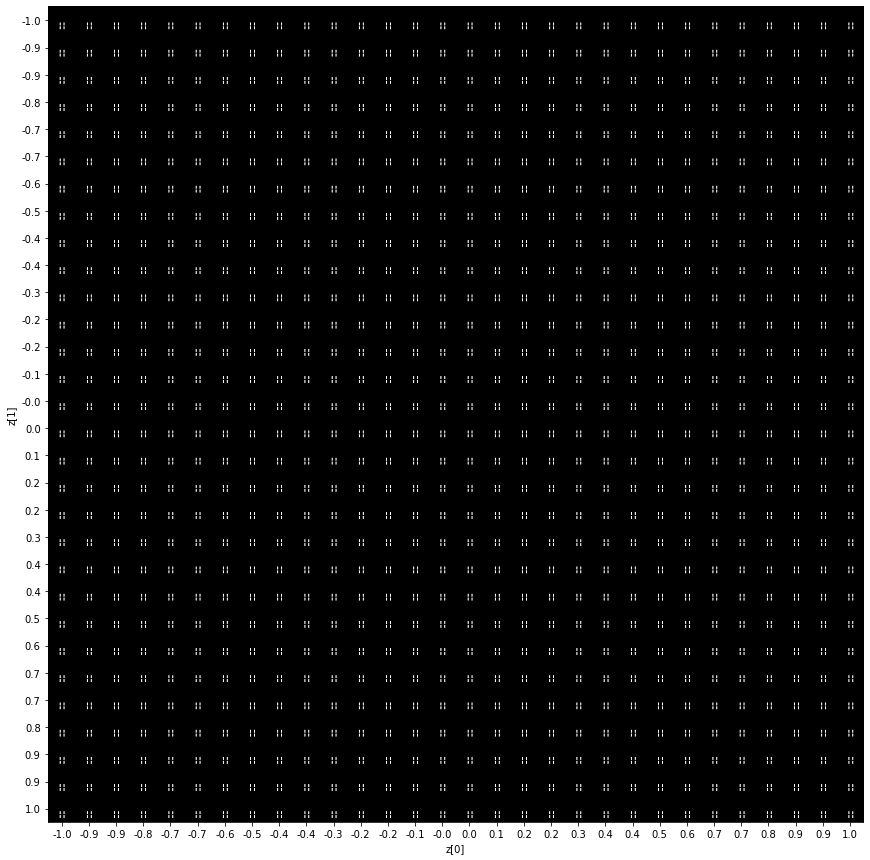

2021-12-29 18:09:21 INFO: 2050 0.007 7.220
2021-12-29 18:09:22 INFO: 2100 0.000 8.904
2021-12-29 18:09:22 INFO: 2150 0.000 8.712
2021-12-29 18:09:23 INFO: 2200 0.000 8.546
2021-12-29 18:09:23 INFO: 2250 0.000 8.898
2021-12-29 18:09:24 INFO: 2300 0.000 9.301
2021-12-29 18:09:24 INFO: 2350 0.001 8.918
2021-12-29 18:09:25 INFO: 2400 0.000 9.290
2021-12-29 18:09:25 INFO: 2450 0.000 8.705
2021-12-29 18:09:26 INFO: 2500 0.000 8.144
2021-12-29 18:09:26 INFO: 2550 0.000 8.817
2021-12-29 18:09:27 INFO: 2600 0.000 9.423
2021-12-29 18:09:28 INFO: 2650 0.000 9.209
2021-12-29 18:09:28 INFO: 2700 0.000 8.907
2021-12-29 18:09:29 INFO: 2750 0.000 9.272
2021-12-29 18:09:29 INFO: 2800 0.000 9.795
2021-12-29 18:09:30 INFO: 2850 0.000 9.870
2021-12-29 18:09:30 INFO: 2900 0.000 9.944
2021-12-29 18:09:31 INFO: 2950 0.000 9.610
2021-12-29 18:09:31 INFO: 3000 0.000 8.797
2021-12-29 18:09:32 INFO: 3050 0.000 9.663
2021-12-29 18:09:32 INFO: 3100 0.000 9.714
2021-12-29 18:09:33 INFO: 3150 0.000 10.332
2021-12-29

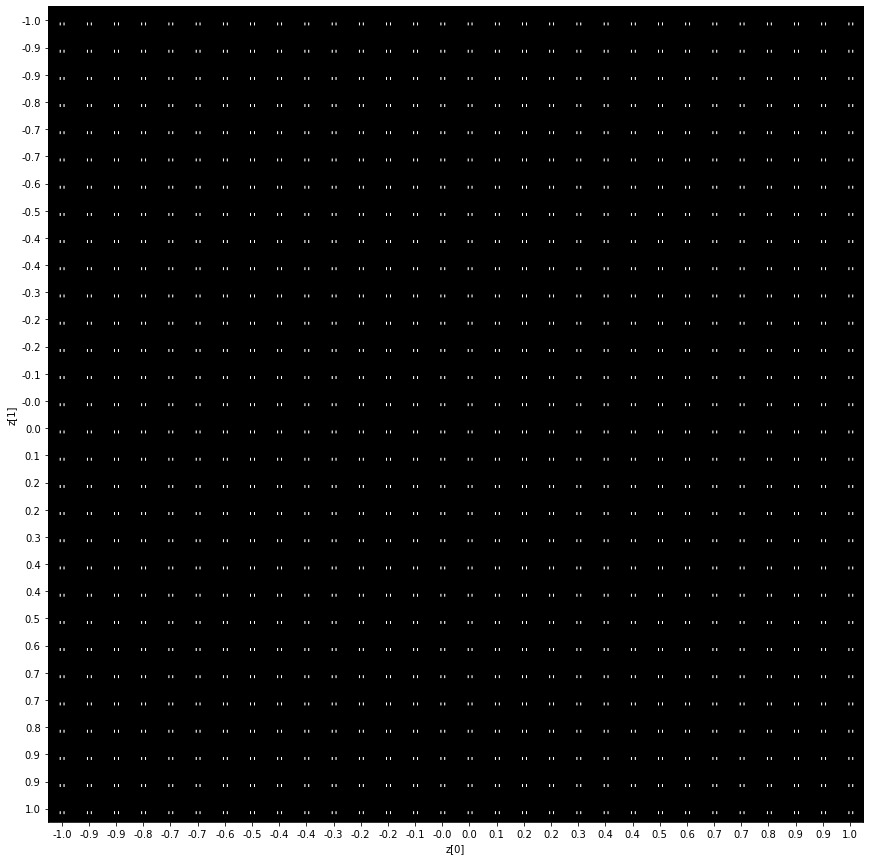

2021-12-29 18:09:43 INFO: 4050 0.000 10.553
2021-12-29 18:09:44 INFO: 4100 0.000 11.047
2021-12-29 18:09:45 INFO: 4150 0.000 11.304
2021-12-29 18:09:45 INFO: 4200 0.000 11.164
2021-12-29 18:09:46 INFO: 4250 0.000 11.398
2021-12-29 18:09:46 INFO: 4300 0.000 11.007
2021-12-29 18:09:47 INFO: 4350 0.000 11.390
2021-12-29 18:09:47 INFO: 4400 0.000 11.454
2021-12-29 18:09:48 INFO: 4450 0.000 10.715
2021-12-29 18:09:48 INFO: 4500 0.000 10.365


KeyboardInterrupt: 

In [65]:
wd_loss = 100
wg_loss = 100
count = 0

lossf = nn.BCELoss()

while True:
    count += 1
    gamma = max(1 / count, gamma)

    G.train()
    D.train()

    idx = torch.randint(train.shape[0], (batch_size,))
    real = train[idx]
    fake = gen(batch_size)
    d_real = D(real)

    vf = torch.ones_like(d_real)
    ff = torch.zeros_like(d_real)

    DO.zero_grad()

    d_loss = (lossf(d_real, vf) + lossf(D(fake.detach()), ff)) * 0.5
    d_loss.backward(retain_graph=True)

    DO.step()
    wd_loss = d_loss.item() * gamma + wd_loss * (1 - gamma)
    
    GO.zero_grad()

    g_loss = lossf(D(fake), vf)
    g_loss.backward()

    GO.step()
    wg_loss = g_loss.item() * gamma + wg_loss * (1 - gamma)

    if count % log_int == 0:
        logging.info(f'{count} {wd_loss:.3f} {wg_loss:.3f}')

    if count % 2000 == 0:
        G.eval()
        plot_latent_space()